## Finetuning the GPT_MODEL for classification of messages as "Spam" and "Not Spam"

### Downloading and unzipping the dataset

In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path

url  = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_colectio.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(
    url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction")
        return
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File Downloaded and saved as {data_file_path}")
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction


In [2]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


### Creating a balanced dataset of 747 examples of each class and mapping "spam" to 1 and "ham" to 0

In [4]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"]=="spam"].shape[0]
    ham_subset = df[df["Label"]=="ham"].sample(num_spam, random_state=123)
    balanced_dataset = pd.concat([ham_subset, df[df["Label"]=="spam"]])
    return balanced_dataset
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [5]:
balanced_df["Label"] = balanced_df["Label"].map({"ham":0, "spam":1})
balanced_df.head()

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?


### Splitting the balanced_df into training, validation and testing dataframes in the ration 7:1:2 respectively

In [6]:
def random_split(df, train_frac, val_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    train_end = int(train_frac*len(df))
    val_end = int((train_frac+val_frac)*len(df))
    
    train_df = df[:train_end]
    val_df = df[train_end:val_end]
    test_df = df[val_end:]
    
    return train_df, val_df, test_df
train_df, val_df, test_df = random_split(balanced_df, 0.7, 0.1)

**Saving each dataframe as a CSV file**

In [7]:
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)

### Creating custom dataset class

In [8]:
import torch
from torch.utils.data import DataLoader, Dataset
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None,
                 pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            
            self.encoded_texts = [text[:self.max_length] for text in self.encoded_texts]
        
        self.encoded_texts = [
            encoded_text + [pad_token_id]*(self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
        
    def __getitem__(self, idx):
        encoded = self.encoded_texts[idx]
        label = self.data.iloc[idx]["Label"]
        encoded = torch.tensor(encoded, dtype=torch.long)
        label = torch.tensor(label, dtype=torch.long)
        return (encoded, label)
    def __len__(self):
        return len(self.data)
    def _longest_encoded_length(self):
        max_len = 0
        for enc_text in self.encoded_texts:
            if len(enc_text)>max_len: max_len = len(enc_text)
        return max_len
            
        

In [9]:

train_dataset = SpamDataset(csv_file="train.csv", tokenizer=tokenizer)
val_dataset = SpamDataset(csv_file="val.csv", tokenizer=tokenizer, max_length=train_dataset.max_length)
test_dataset = SpamDataset(csv_file="test.csv", tokenizer=tokenizer, max_length=train_dataset.max_length)

### Creating dataloaders

In [10]:
num_workers=0
batch_size=8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

### Defining Model Configurations

In [11]:
CHOOSE_MODEL = "gpt2-small (124M)"
BASE_CONFIG = {
    "vocab_size":50257,
    "context_length":1024,
    "drop_rate":0.0,
    "qkv_bias":True
    }
model_configs = {
    'gpt2-small (124M)': {'emb_dim': 768, 'n_layers': 12, 'n_heads': 12},
    'gpt2-medium (355M)': {'emb_dim': 1024, 'n_layers': 24, 'n_heads': 16},
    'gpt2-large (774M)': {'emb_dim': 1280, 'n_layers': 36, 'n_heads': 20},
    'gpt2-xl (1558M)': {'emb_dim': 1600, 'n_layers': 48, 'n_heads': 25}
    }
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
BASE_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'drop_rate': 0.0,
 'qkv_bias': True,
 'emb_dim': 768,
 'n_layers': 12,
 'n_heads': 12}

In [12]:
from gpt_download import download_and_load_gpt2
from base_model import load_params_into_gpt, GPTModel

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)

load_params_into_gpt(model, params)

model.eval();

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


### Testing if weights are loaded correctly in the model architecture by generating some text

In [13]:
from base_model import generate

input_context = "The age of the sun is"

generate(model=model, tokenizer=tokenizer,
         input_context=input_context, max_new_tokens=50,
         context_size=BASE_CONFIG["context_length"],
         temperature=1, top_k=7)

The age of the sun is approaching. We are in the midst of a time of great changes, and it is time to look at our surroundings to see how the sun may change our day, and to see how it may affect how we live. It is time to look into


### Architecture of the model

In [14]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer_layer): Sequential(
    (0): Transformer(
      (layer_norm1): layer_norm()
      (Masked_multi_head_attn): MultiHeadAttention(
        (Q_layer): Linear(in_features=768, out_features=768, bias=True)
        (K_layer): Linear(in_features=768, out_features=768, bias=True)
        (V_layer): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (layer_norm2): layer_norm()
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): Transformer(
      (layer_norm1): layer_norm()
      (Masked

### Freezing all the parameters because only few layers will be fine tuned

In [15]:
for params in model.parameters():
    params.requires_grad = False

### Replacing the last linear_out_layer with a Linear layer having out_features 2

In [16]:
import torch.nn as nn
torch.manual_seed(353)

num_classes = 2

model.linear_out_layer = nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

### Allowing the last transformer layer and final normalization layer to be trained for better accuracy

In [17]:
for params in model.transformer_layer[-1].parameters():
    params.requires_grad = True
for params in model.final_norm_layer.parameters():
    params.requires_grad = True

### Function to calculate accuracy of a dataloader

In [18]:
def cal_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    num_correct_pred, num_examples = 0, 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(len(data_loader), num_batches)
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)
            num_examples += predicted_labels.shape[0]
            num_correct_pred += (
                (predicted_labels==target_batch).sum().item()
            )
        else:
            break
    return num_correct_pred/num_examples

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Train acc: {cal_accuracy_loader(train_loader, model, device)*100:.2f}%")
print(f"Validation acc: {cal_accuracy_loader(val_loader, model, device)*100:.2f}%")
print(f"Test acc: {cal_accuracy_loader(test_loader, model, device)*100:.2f}%")

Train acc: 51.92%
Validation acc: 63.33%
Test acc: 52.17%


### Loss function

In [20]:
def calc_batch_lossFT(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = nn.functional.cross_entropy(logits, target_batch)
    return loss

In [21]:
def calc_loader_lossFT(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader)==0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i , (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_batch_lossFT(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches

In [22]:
print(f"Training loss: {calc_loader_lossFT(train_loader, model, device):.3f}")
print(f"Validation loss: {calc_loader_lossFT(val_loader, model, device):.3f}")
print(f"Test loss: {calc_loader_lossFT(test_loader, model, device):.3f}")

Training loss: 0.693
Validation loss: 0.687
Test loss: 0.693


### Evaluation function

In [23]:
def evaluate_modelFT(train_loader, val_loader, model, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loader_lossFT(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loader_lossFT(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

### Training function

In [24]:
def train_func(
    model, train_loader, val_loader,
    num_epochs, optimizer, device, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_batch_lossFT(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1
            if global_step%eval_freq==0:
                train_loss, val_loss = evaluate_modelFT(train_loader, val_loader, model, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Training loss: {train_loss:.3f}, "
                    f"Val loss : {val_loss:.3f}")
        train_acc = cal_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter)
        val_acc = cal_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_acc*100:.3f}% | ", end="")
        print(f"Validation accuracy: {val_acc*100:.3f}%")
        train_accs.append(train_acc)
        val_accs.append(val_acc)
    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [25]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_lossesFT, val_lossesFT, train_accsFT, val_accsFT, examples_seen = train_func(
    model, train_loader, val_loader,
    num_epochs, optimizer, device, eval_freq=50, eval_iter=5)

end_time = time.time()
execution_time_minutes = (end_time - start_time)/60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Training loss: 0.705, Val loss : 0.696
Ep 1 (Step 000050): Training loss: 0.619, Val loss : 0.632
Ep 1 (Step 000100): Training loss: 0.412, Val loss : 0.489
Training accuracy: 85.000% | Validation accuracy: 95.000%
Ep 2 (Step 000150): Training loss: 0.454, Val loss : 0.277
Ep 2 (Step 000200): Training loss: 0.070, Val loss : 0.055
Ep 2 (Step 000250): Training loss: 0.034, Val loss : 0.127
Training accuracy: 92.500% | Validation accuracy: 97.500%
Ep 3 (Step 000300): Training loss: 0.122, Val loss : 0.140
Ep 3 (Step 000350): Training loss: 0.047, Val loss : 0.029
Training accuracy: 97.500% | Validation accuracy: 97.500%
Ep 4 (Step 000400): Training loss: 0.009, Val loss : 0.029
Ep 4 (Step 000450): Training loss: 0.073, Val loss : 0.053
Ep 4 (Step 000500): Training loss: 0.136, Val loss : 0.025
Training accuracy: 97.500% | Validation accuracy: 97.500%
Ep 5 (Step 000550): Training loss: 0.181, Val loss : 0.017
Ep 5 (Step 000600): Training loss: 0.045, Val loss : 0.030
T

### Plotting losses and accuracies

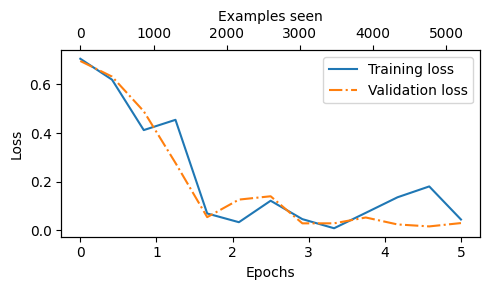

In [26]:
import matplotlib.pyplot as plt

def plot_values(
    epochs_seen, examples_seen, train_values, val_values,
    label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_lossesFT))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_lossesFT))

plot_values(epochs_tensor, examples_seen_tensor, train_lossesFT, val_lossesFT)

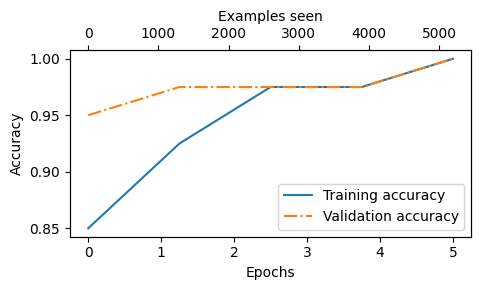

In [27]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accsFT))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accsFT))

plot_values(epochs_tensor, examples_seen_tensor, train_accsFT, val_accsFT, label="accuracy")

### Calculating accuracies on datasets

In [28]:
train_acc = cal_accuracy_loader(train_loader, model, device)
val_acc = cal_accuracy_loader(val_loader, model, device)
test_acc = cal_accuracy_loader(test_loader, model, device)
print(f"Training accuracy: {train_acc*100:.2f}%")
print(f"Validation accuracy: {val_acc*100:.2f}%")
print(f"Test accuracy: {test_acc*100:.2f}%")

Training accuracy: 97.98%
Validation accuracy: 97.33%
Test accuracy: 96.66%


### Testing out fine-tuned model on unseen data

In [29]:
def classify_email(
    text, model, tokenizer, max_length=None, pad_token_id=50256):
    model.eval()
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]
    input_ids = input_ids[:min(max_length, supported_context_length)]
    input_ids = input_ids + [pad_token_id]*(max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)
    
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_lebel = torch.argmax(logits, dim=-1).item()
    return "Not Spam" if predicted_lebel==0 else "Spam"

In [30]:
Text1 = "Congratulations! You’ve won a $500 gift card. Click here to claim your prize now!"
Text2 = "Hey, are we still meeting at the library at 5 pm today?"

label1 = classify_email(Text1, model, tokenizer, train_dataset.max_length)
label2 = classify_email(Text2, model, tokenizer, train_dataset.max_length)

print(f"Text1 is {label1}\n"
      f"Text2 is {label2}")

Text1 is Spam
Text2 is Not Spam


### Saving the model

In [31]:
torch.save(model.state_dict(), "review_classifier.pth")